In [122]:
# Librerías de datos y visualización
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import seaborn as sns

In [123]:
secciones = gpd.read_file('datos/secciones-electorales-pba.geojson')
secciones

,fid,fna,gna,nam,sag,seccion,geometry
0,1.0,Partido de Vicente López,Partido,Vicente López,IDEBA,I,"MULTIPOLYGON (((-58.523 -34.5976, -58.5231 -34..."
1,2.0,Partido de Rojas,Partido,Rojas,IDEBA,II,"MULTIPOLYGON (((-59.1967 -34.3737, -59.1967 -3..."
2,3.0,Partido de Magdalena,Partido,Magdalena,IDEBA,III,"MULTIPOLYGON (((-57.2767 -35.2257, -57.2766 -3..."
3,4.0,Partido de General Pinto,Partido,General Pinto,IDEBA,IV,"MULTIPOLYGON (((-61.2698 -36.0711, -61.2699 -3..."
4,5.0,Partido de General Lavalle,Partido,General Lavalle,IDEBA,V,"MULTIPOLYGON (((-59.3328 -38.7367, -59.3328 -3..."
5,6.0,Partido de Coronel Suárez,Partido,Coronel Suárez,IDEBA,VI,"MULTIPOLYGON (((-62.2489 -39.817, -62.2491 -39..."
6,7.0,Partido de Saladillo,Partido,Saladillo,IDEBA,VII,"MULTIPOLYGON (((-59.4882 -36.2271, -59.4881 -3..."
7,8.0,Partido de La Plata,Partido,La Plata,IDEBA,VIII,"MULTIPOLYGON (((-57.8082 -34.9621, -57.8038 -3..."


In [ ]:
# Cantidad de bancas por sección
secciones_diputados = {
    "Capital": 6,
    "Segunda": 11,
    "Tercera": 18,
    "Sexta": 11    
}

secciones_senadores = {
    "Primera": 8,
    "Cuarta": 7,
    "Quinta": 5,
    "Séptima": 3
}

# Padrón real por sección (actualizado)
padron_real = {
    "Capital": 576_691,
    "Primera": 4_732_831,
    "Segunda": 649_465,
    "Tercera": 4_637_863,
    "Cuarta": 540_354,
    "Quinta": 1_290_948, 
    "Sexta": 652_077, 
    "Séptima": 281_130
}

listas_politicas = [
    "Alianza La Libertad Avanza",  # PRO + LLA
    "Fuerza Patria",               # UxP
    "Somos Buenos Aires",          # UCR + PJ no K
    "Avanza Libertad",             # Libertarios - BLUE
    "FIT-U"                        # Izquierda
]

# # Sesgo Dirichlet según importancia política
# pesos_dirichlet = [5, 5, 3, 1.5, 0.2]

# # Input: lista de porcentajes que suman 100
# creencias = [36, 35, 15, 10, 4]  # por ejemplo, lo que cree un usuario

# # Convertimos a pesos Dirichlet (normalizás con un "concentración" deseada)
# concentracion = 70  # cuanto más grande, menos aleatorio
# pesos_dirichlet = [p * concentracion / 100 for p in creencias]

# Parámetros de simulación
participacion = 0.60
votos_validos_pct = 0.90
# np.random.seed(42)

In [155]:
def simular_votos(padron_real, secciones_camara, listas, pesos_dirichlet, participacion, votos_validos_pct):
    data = []
    for seccion, cargos in secciones_camara.items():
        padron = padron_real[seccion]
        votos_emitidos = padron * participacion
        votos_validos = int(votos_emitidos * votos_validos_pct)

        proporciones = np.random.dirichlet(pesos_dirichlet)
        votos_listas = (proporciones * votos_validos).astype(int)

        for lista, votos in zip(listas, votos_listas):
            data.append({
                "seccion": seccion,
                "lista": lista,
                "votos": votos,
                "total_votos": votos_validos,
                "cargos": cargos
            })

    return pd.DataFrame(data)

# Simulamos ambas cámaras por separado
df_diputados = simular_votos(padron_real, secciones_diputados, listas_politicas, pesos_dirichlet, participacion, votos_validos_pct)
df_senadores = simular_votos(padron_real, secciones_senadores, listas_politicas, pesos_dirichlet, participacion, votos_validos_pct)


In [ ]:
# def repartir_bancas(df):
#     resultados = []

#     for seccion, grupo in df.groupby("seccion"):
#         total_votos = grupo["votos"].sum()
#         cargos      = grupo["cargos"].iloc[0]
#         # cuociente   = total_votos // cargos
#         cuociente   = max(1, total_votos // cargos)        # ← asegura ≥1

#         # Paso 1 ─ Cálculo inicial
#         grupo = grupo.copy()
#         grupo["enteros"] = grupo["votos"] // cuociente
#         grupo["residuo"] = grupo["votos"] % cuociente
#         grupo["bancas"]  = grupo["enteros"]

#         # Paso 2 ─ DESCARTAR listas sin cuociente
#         grupo.loc[grupo["enteros"] == 0, ["residuo"]] = -1   # queda fuera de la puja
#         bancas_asignadas = grupo["bancas"].sum()

#         # Paso 3 ─ Repartir restos solo entre las que tienen ≥1 cuociente
#         faltan = cargos - bancas_asignadas
#         if faltan > 0:
#             elegibles = grupo[grupo["enteros"] > 0]               # solo estas compiten
#             elegibles = elegibles.sort_values(
#                 ["residuo", "votos"], ascending=False
#             ).head(faltan).index
#             grupo.loc[elegibles, "bancas"] += 1

#         # Paso 4 ─ Art. 110 (ningún partido llegó al cuociente)
#         if grupo["bancas"].sum() == 0:
#             nuevo_cuoc = cuociente
#             while grupo["bancas"].sum() == 0:
#                 nuevo_cuoc = max(1, nuevo_cuoc // 2)
#                 grupo["enteros"] = grupo["votos"] // nuevo_cuoc
#                 grupo["residuo"] = grupo["votos"] %  nuevo_cuoc
#                 grupo["bancas"]  = grupo["enteros"]
#                 bancas_asignadas = grupo["bancas"].sum()

#                 faltan = cargos - bancas_asignadas
#                 if faltan > 0:
#                     elegibles = grupo[grupo["enteros"] > 0]
#                     elegibles = elegibles.sort_values(
#                         ["residuo", "votos"], ascending=False
#                     ).head(faltan).index
#                     grupo.loc[elegibles, "bancas"] += 1

#         resultados.append(grupo[["seccion", "lista", "bancas"]])

#     return pd.concat(resultados).reset_index(drop=True)


In [167]:
def repartir_bancas(df):
    out = []

    for seccion, grupo in df.groupby("seccion"):
        total_votos = grupo["votos"].sum()
        cargos      = grupo["cargos"].iloc[0]
        cuociente   = max(1, total_votos // cargos)        # ← asegura ≥1

        grupo = grupo.copy()
        grupo["enteros"] = grupo["votos"] // cuociente
        grupo["residuo"] = grupo["votos"] %  cuociente
        grupo["bancas"]  = grupo["enteros"]

        # ── Restos solo entre listas con ≥1 cuociente
        faltan = cargos - grupo["bancas"].sum()
        if faltan:
            elig = grupo[grupo["enteros"] > 0]
            if not elig.empty:
                idx = (elig.sort_values(["residuo", "votos"],
                                        ascending=False)
                             .head(faltan).index)
                grupo.loc[idx, "bancas"] += 1

        # ── Art. 110: nadie alcanzó cuociente
        if grupo["bancas"].sum() == 0:
            q = cuociente
            while grupo["bancas"].sum() == 0:
                q = max(1, q // 2)
                grupo["enteros"] = grupo["votos"] // q
                grupo["residuo"] = grupo["votos"] %  q
                grupo["bancas"]  = grupo["enteros"]

                faltan = cargos - grupo["bancas"].sum()
                if faltan:
                    elig = grupo[grupo["enteros"] > 0]
                    if not elig.empty:
                        idx = (elig.sort_values(["residuo", "votos"],
                                                ascending=False)
                                       .head(faltan).index)
                        grupo.loc[idx, "bancas"] += 1

        # ── Paso 5: completar con la lista más votada
        faltan = cargos - grupo["bancas"].sum()
        if faltan:
            top = grupo["votos"].idxmax()
            grupo.loc[top, "bancas"] += faltan

        out.append(grupo[["seccion", "lista", "bancas"]])

    return pd.concat(out, ignore_index=True)


In [ ]:
# def repartir_bancas(df):
#     resultados = []
#     for seccion, grupo in df.groupby("seccion"):
#         total_votos = grupo["votos"].sum()
#         cargos = grupo["cargos"].iloc[0]
#         cuociente = total_votos // cargos

#         grupo = grupo.copy()
#         grupo["enteros"] = grupo["votos"] // cuociente
#         grupo["residuo"] = grupo["votos"] % cuociente
#         grupo["bancas"] = grupo["enteros"]

#         faltan = cargos - grupo["bancas"].sum()
#         if faltan > 0:
#             grupo = grupo.sort_values(["residuo", "votos"], ascending=False)
#             grupo.iloc[:faltan, grupo.columns.get_loc("bancas")] += 1

#         resultados.append(grupo[["seccion", "lista", "votos", "bancas"]])

#     return pd.concat(resultados).reset_index(drop=True)

df_bancas_diputados = repartir_bancas(df_diputados)
df_bancas_senadores = repartir_bancas(df_senadores)



In [168]:
import numpy as np, pandas as pd
np.random.seed(123)

def simular_eleccion(dirichlet_pesos, phi=None):
    """Devuelve df_bancas_diputados y df_bancas_senadores para 1 corrida."""
    # 1) proporción provincial (si usás modelo jerárquico)
    if phi is not None:
        P_prov = np.random.dirichlet(dirichlet_pesos)

    # ------- helpers ----------
    def simular_y_repartir(secciones_camara):
        filas = []
        for sec, cargos in secciones_camara.items():
            pad = padron_real[sec]
            votos_validos = int(pad * participacion * votos_validos_pct)

            if phi is None:  # Dirichlet independiente
                prop = np.random.dirichlet(dirichlet_pesos)
            else:            # Jerárquico
                prop = np.random.dirichlet(P_prov * phi)

            votos = (prop * votos_validos).astype(int)
            for lista, v in zip(listas_politicas, votos):
                filas.append({"seccion": sec, "lista": lista,
                              "votos": v, "cargos": cargos})
        df = pd.DataFrame(filas)
        return repartir_bancas(df)

    dip = simular_y_repartir(secciones_diputados)
    sen = simular_y_repartir(secciones_senadores)
    return dip, sen

# # ---------- MONTE CARLO -----------
N = 1000
# Input: lista de porcentajes que suman 100
creencias = [36, 35, 15, 10, 4]  # por ejemplo, lo que cree un usuario
alpha_scale = 25
pesos_dirichlet = np.array(creencias) * alpha_scale / 100 #alphas


dip_acum, sen_acum = [], []
for _ in range(N):
    d,s = simular_eleccion(pesos_dirichlet, phi=50)
    dip_acum.append(d.groupby("lista").bancas.sum())
    sen_acum.append(s.groupby("lista").bancas.sum())

dip_mc = pd.DataFrame(dip_acum).reindex(columns=listas_politicas).fillna(0)
sen_mc = pd.DataFrame(sen_acum).reindex(columns=listas_politicas).fillna(0)

def resumen(df):
    return pd.DataFrame({
        "media": df.mean(),
        "p5":    df.quantile(0.05),
        "p95":   df.quantile(0.95)
    }).round(2)   

tbl_dip = resumen(dip_mc)
tbl_sen = resumen(sen_mc)

print("\nBANCAS EN DIPUTADOS ({} simulaciones)".format(N))
print(tbl_dip)
print("\nBANCAS EN SENADO ({} simulaciones)".format(N))
print(tbl_sen)


BANCAS EN DIPUTADOS (1000 simulaciones)
                            media   p5   p95
lista                                       
Alianza La Libertad Avanza  17.48  9.0  26.0
Fuerza Patria               17.31  9.0  26.0
Somos Buenos Aires           6.63  0.0  14.0
Avanza Libertad              3.61  0.0  10.0
FIT-U                        0.97  0.0   5.0

BANCAS EN SENADO (1000 simulaciones)
                            media   p5   p95
lista                                       
Alianza La Libertad Avanza   9.68  4.0  15.0
Fuerza Patria                9.49  4.0  15.0
Somos Buenos Aires           2.54  0.0   8.0
Avanza Libertad              1.08  0.0   5.0
FIT-U                        0.21  0.0   2.0


In [180]:
def resumen_con_enteros(df_mc):
    """
    df_mc … DataFrame de Monte Carlo (filas = sims, cols = partidos).
    Devuelve media, p5, p95 y media_int / moda.
    """
    media = df_mc.mean()
    p5    = df_mc.quantile(0.05)
    p95   = df_mc.quantile(0.95)
    
    media_int = media.round().astype(int)                 # entero más cercano
    
    out = pd.concat(
        [media, p5, p95, media_int], 
        axis=1, 
        keys=["media", "p5", "p95", "media_int"]
    )
    # media queda con decimales; los enteros se ven sin ".0"
    out[["media_int"]] = out[["media_int"]].astype(int)
    return out

tbl_dip = resumen_con_enteros(dip_mc)
tbl_sen = resumen_con_enteros(sen_mc)

print("\n CÁMARA DE DIPUTADOS (1000 sims)")
print(tbl_dip.to_string())

print("\n SENADO PROVINCIAL (1000 sims)")
print(tbl_sen.to_string())



 CÁMARA DE DIPUTADOS (1000 sims)
                             media   p5   p95  media_int
lista                                                   
Alianza La Libertad Avanza  17.478  9.0  26.0         17
Fuerza Patria               17.310  9.0  26.0         17
Somos Buenos Aires           6.634  0.0  14.0          7
Avanza Libertad              3.607  0.0  10.0          4
FIT-U                        0.971  0.0   5.0          1

 SENADO PROVINCIAL (1000 sims)
                            media   p5   p95  media_int
lista                                                  
Alianza La Libertad Avanza  9.683  4.0  15.0         10
Fuerza Patria               9.495  4.0  15.0          9
Somos Buenos Aires          2.540  0.0   8.0          3
Avanza Libertad             1.075  0.0   5.0          1
FIT-U                       0.207  0.0   2.0          0


In [178]:
def vector_entero(df_mc, total_bancas):
    media = df_mc.mean()                    # media fraccionaria por partido
    base  = np.floor(media).astype(int)     # parte entera
    faltan = total_bancas - base.sum()      # cuántas bancas sin asignar
    resid = (media - base).sort_values(ascending=False)
    base[resid.index[:faltan]] += 1
    return base

dip_expect = vector_entero(dip_mc, 46)      # 6+11+18+11
sen_expect = vector_entero(sen_mc, 23)      # 8+7+5+3

print("Diputados – vector entero coherente")
print(dip_expect.to_string())

print("\nSenado – vector entero coherente")
print(sen_expect.to_string())


Diputados – vector entero coherente
lista
Alianza La Libertad Avanza    17
Fuerza Patria                 17
Somos Buenos Aires             7
Avanza Libertad                4
FIT-U                          1

Senado – vector entero coherente
lista
Alianza La Libertad Avanza    10
Fuerza Patria                  9
Somos Buenos Aires             3
Avanza Libertad                1
FIT-U                          0


In [169]:
from scipy.spatial.distance import cdist

def medoid(df):
    df = df.fillna(0)                         # ← limpia NaN
    if df.empty:
        raise ValueError("DataFrame vacío")
    D = cdist(df.values, df.values, metric="cityblock")
    idx = np.nanargmin(D.sum(axis=1))        # ← ignora NaN en cálculo
    return df.iloc[idx].astype(int)          # ← vector entero


dip_medoid = medoid(dip_mc)
sen_medoid = medoid(sen_mc)
print("\nMedoid de Diputados:")
print(dip_medoid.to_string())
print("\nMedoid de Senadores:")
print(sen_medoid.to_string())



Medoid de Diputados:
lista
Alianza La Libertad Avanza    17
Fuerza Patria                 18
Somos Buenos Aires             7
Avanza Libertad                4
FIT-U                          0

Medoid de Senadores:
lista
Alianza La Libertad Avanza    11
Fuerza Patria                 10
Somos Buenos Aires             2
Avanza Libertad                0
FIT-U                          0


In [170]:
from scipy.spatial.distance import cdist

def medoid(df):
    M = cdist(df.values, df.values, metric="cityblock")   # matriz NxN
    idx = M.sum(axis=1).argmin()                          # fila más “central”
    return df.iloc[idx]

medoid_dip = medoid(dip_mc)
medoid_sen = medoid(sen_mc)

print("Diputados – mediana multivariada")
print(medoid_dip)
print("Senado – mediana multivariada")
print(medoid_sen)


Diputados – mediana multivariada
lista
Alianza La Libertad Avanza    17
Fuerza Patria                 18
Somos Buenos Aires             7
Avanza Libertad                4
FIT-U                          0
Name: bancas, dtype: int64
Senado – mediana multivariada
lista
Alianza La Libertad Avanza    11
Fuerza Patria                 10
Somos Buenos Aires             2
Avanza Libertad                0
FIT-U                          0
Name: bancas, dtype: int64


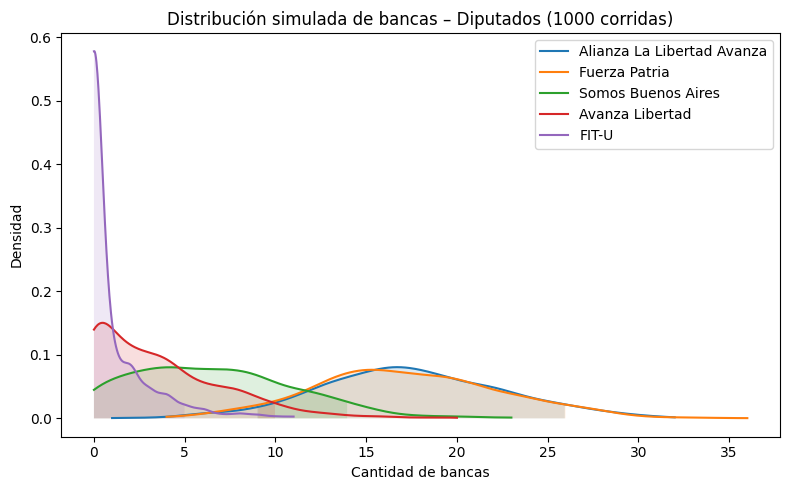

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde   # viene con SciPy

# dip_mc es el DataFrame con las 1000 simulaciones (filas) y partidos (columnas)

plt.figure(figsize=(8,5))

for partido in dip_mc.columns:
    datos = dip_mc[partido].values
    # --- curva KDE ---
    kde  = gaussian_kde(datos, bw_method='scott')   # suavizado automático
    xs   = np.linspace(datos.min(), datos.max(), 400)
    dens = kde(xs)
    plt.plot(xs, dens, label=partido)               # línea suave
    
    # --- intervalo p5–p95 ---
    p5, p95 = np.percentile(datos, [5, 95])
    mask = (xs >= p5) & (xs <= p95)
    plt.fill_between(xs[mask], dens[mask], alpha=0.15)   # misma tonalidad, +transparencia

plt.title("Distribución simulada de bancas – Diputados (1000 corridas)")
plt.xlabel("Cantidad de bancas")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


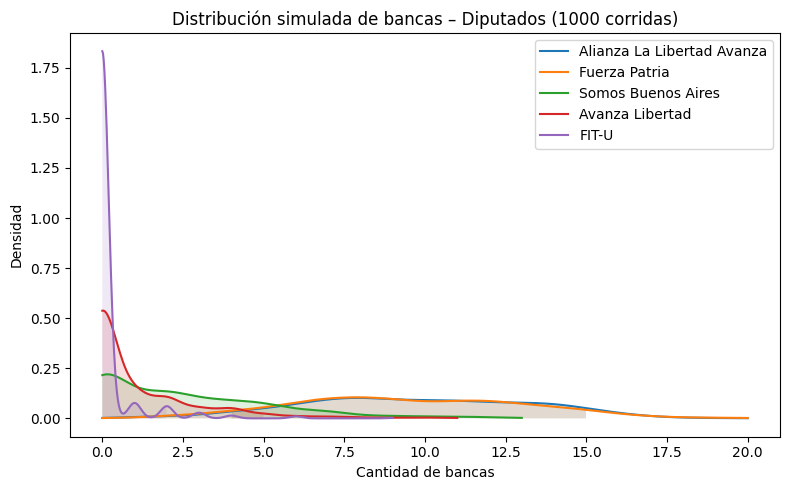

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde   # viene con SciPy

# dip_mc es el DataFrame con las 1000 simulaciones (filas) y partidos (columnas)

plt.figure(figsize=(8,5))

for partido in sen_mc.columns:
    datos = sen_mc[partido].values
    # --- curva KDE ---
    kde  = gaussian_kde(datos, bw_method='scott')   # suavizado automático
    xs   = np.linspace(datos.min(), datos.max(), 400)
    dens = kde(xs)
    plt.plot(xs, dens, label=partido)               # línea suave
    
    # --- intervalo p5–p95 ---
    p5, p95 = np.percentile(datos, [5, 95])
    mask = (xs >= p5) & (xs <= p95)
    plt.fill_between(xs[mask], dens[mask], alpha=0.15)   # misma tonalidad, +transparencia

plt.title("Distribución simulada de bancas – Diputados (1000 corridas)")
plt.xlabel("Cantidad de bancas")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


In [128]:
# DIPUTADOS
bancas_diputados = (
    df_bancas_diputados.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Diputados"})
)

# SENADORES
bancas_senadores = (
    df_bancas_senadores.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Senado"})
)

# Mostrar tablas
print("\n Bancas en Diputados:")
print(bancas_diputados.to_string(index=False))

print("\n Bancas en Senado:")
print(bancas_senadores.to_string(index=False))


 Bancas en Diputados:
                   Partido  Bancas en Diputados
             Fuerza Patria                   20
Alianza La Libertad Avanza                   17
        Somos Buenos Aires                    6
           Avanza Libertad                    2
                     FIT-U                    0

 Bancas en Senado:
                   Partido  Bancas en Senado
Alianza La Libertad Avanza                 9
             Fuerza Patria                 9
        Somos Buenos Aires                 2
                     FIT-U                 0
           Avanza Libertad                 0


In [129]:
ganadores_dip = (
    df_bancas_diputados.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_diputados"})
)

ganadores_sen = (
    df_bancas_senadores.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_senadores"})
)

In [130]:
# Mapeo de números romanos a nombres de sección
romanos_a_nombre = {
    "I": "Primera",
    "II": "Segunda",
    "III": "Tercera",
    "IV": "Cuarta",
    "V": "Quinta",
    "VI": "Sexta",
    "VII": "Séptima",
    "VIII": "Capital"
}

# Función de normalización
def normalizar(texto):
    return str(texto).strip().title()

# Aplicar mapeo y normalización al GeoDataFrame
secciones["seccion"] = secciones["seccion"].map(romanos_a_nombre)
secciones["seccion"] = secciones["seccion"].apply(normalizar)

# Normalizar también los DataFrames de bancas
df_bancas_diputados["seccion"] = df_bancas_diputados["seccion"].apply(normalizar)
df_bancas_senadores["seccion"] = df_bancas_senadores["seccion"].apply(normalizar)

# Crear nueva copia para trabajar visualización
secciones_resultado = secciones.copy()

# Merge con ganadores de cada cámara
secciones_resultado = secciones_resultado.merge(ganadores_dip, on="seccion", how="left")
secciones_resultado = secciones_resultado.merge(ganadores_sen, on="seccion", how="left")


In [131]:
print("Secciones no emparejadas en Diputados:")
print(set(df_bancas_diputados["seccion"]) - set(secciones["seccion"]))

print("Secciones no emparejadas en Senadores:")
print(set(df_bancas_senadores["seccion"]) - set(secciones["seccion"]))


Secciones no emparejadas en Diputados:
set()
Secciones no emparejadas en Senadores:
set()


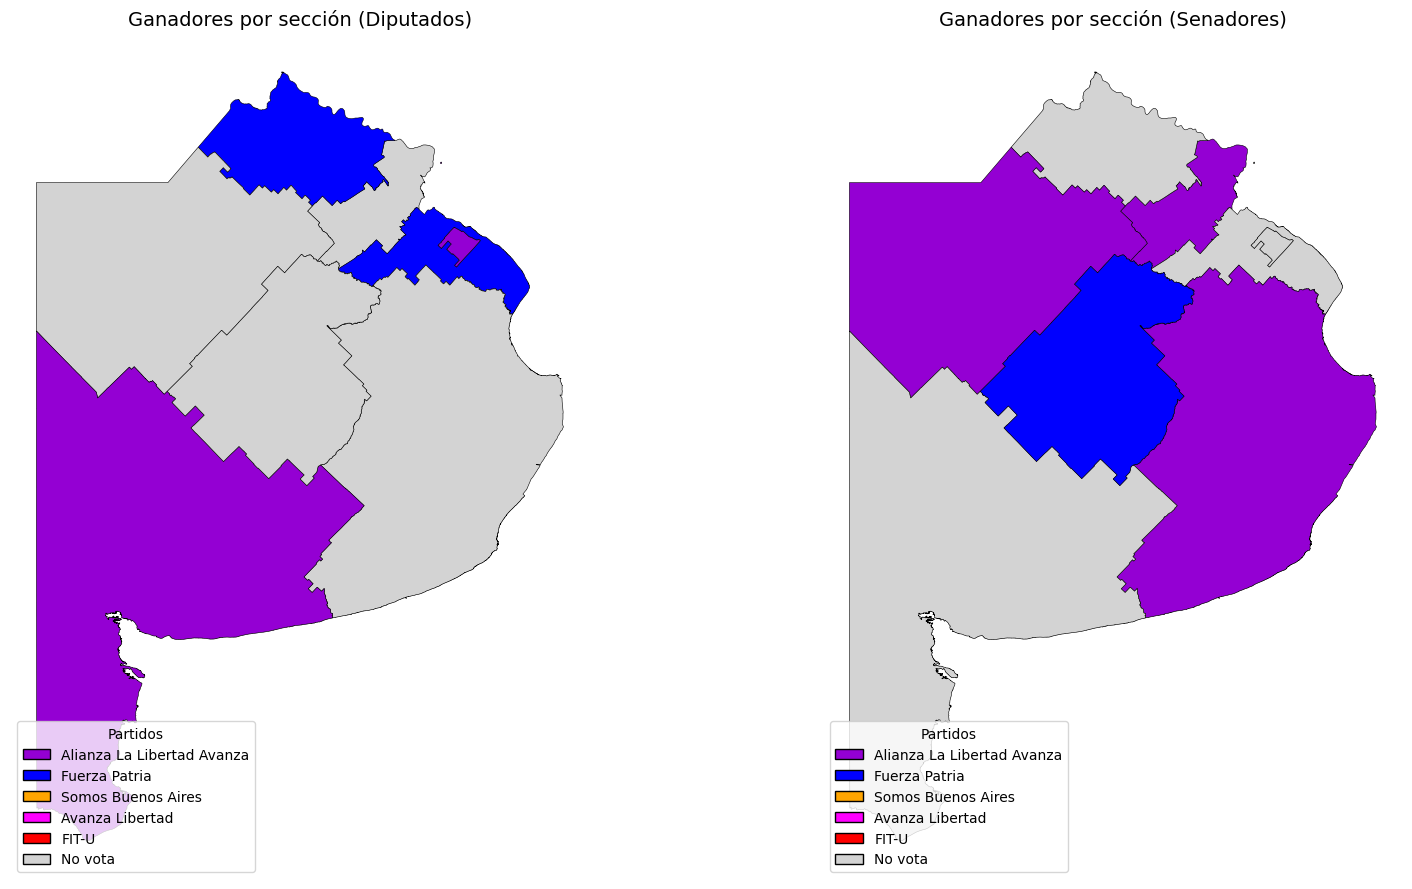

In [132]:
# Diccionario de colores
colores = {
    "Alianza La Libertad Avanza": "darkviolet",
    "Fuerza Patria": "blue",
    "Somos Buenos Aires": "orange",
    "Avanza Libertad": "magenta",
    "FIT-U": "red"
}

# Colores asignados por sección, con gris para NaN
color_diputados = secciones_resultado["ganador_diputados"].map(colores).fillna("lightgray")
color_senadores = secciones_resultado["ganador_senadores"].map(colores).fillna("lightgray")

# Leyenda común
legend_elements = [
    Patch(facecolor=colores[lista], edgecolor='black', label=lista)
    for lista in listas_politicas
]
legend_elements.append(Patch(facecolor="lightgray", edgecolor='black', label="No vota"))

# Crear figuras
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Diputados
secciones_resultado.plot(
    color=color_diputados,
    ax=axs[0],
    edgecolor="black",
    linewidth=0.4
)
axs[0].set_title("Ganadores por sección (Diputados)", fontsize=14)
axs[0].axis("off")
axs[0].legend(handles=legend_elements, loc='lower left', title="Partidos")

# Senadores
secciones_resultado.plot(
    color=color_senadores,
    ax=axs[1],
    edgecolor="black",
    linewidth=0.4
)
axs[1].set_title("Ganadores por sección (Senadores)", fontsize=14)
axs[1].axis("off")
axs[1].legend(handles=legend_elements, loc='lower left', title="Partidos")

plt.tight_layout()
plt.show()


In [133]:
secciones_resultado[["seccion", "ganador_diputados", "ganador_senadores"]]


,seccion,ganador_diputados,ganador_senadores
0,Primera,NaN,Alianza La Libertad Avanza
1,Segunda,Fuerza Patria,NaN
2,Tercera,Fuerza Patria,NaN
3,Cuarta,NaN,Alianza La Libertad Avanza
4,Quinta,NaN,Alianza La Libertad Avanza
5,Sexta,Alianza La Libertad Avanza,NaN
6,Séptima,NaN,Fuerza Patria
7,Capital,Alianza La Libertad Avanza,NaN
